In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from analyticon_fifa.data_loader import load_data
from analyticon_fifa.model import FIFAModel, FEATURES

# Analyticon 2023 Narrative

The FIFA data set contains player rosters for each year from 2015 through 2022, both female and male. However, the female to male proportion of players featured in the game is extremely skewed. Even more so, the ones who are featured lack many data attributes since they are not featured as club players.

We want to explore the differences between female and male players as shown in the data, as a celebration of the FIFA World Cup 2023! Specifically we want to compare the trade value for the players as they relate to the skill attributes. We don't have player value for many female players since they're not signed with a club; we will attack this problem by training an ensemble machine learning model to predict their values via regression.

In [108]:
df = load_data(keep_last=False)

We can see that female players compose a tiny fraction of the total players every year:

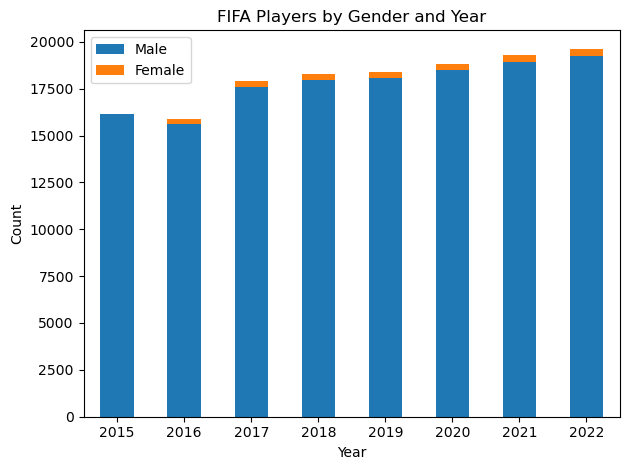

In [109]:
fig, ax = plt.subplots()
yearly = df.groupby("year")["female"].value_counts().unstack().fillna(0).astype(int)
yearly.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    rot=0,
    title="FIFA Players by Gender and Year",
    xlabel="Year",
    ylabel="Count",
)
ax.legend(("Male", "Female"))
fig.tight_layout()

Since we want to compare female to male player performance, we need to do a couple of things first.

1. We will keep the set of players across all years. If a player is seen in more than year, we will keep their latest record.
2. We will drop all players that do not have skill attributes, either male or female.

In [110]:
df = load_data()
df = df[df["pace"].notnull()]
df["gender"] = np.where(df["female"] == 1, "Female", "Male")
df["value_us"] = df["value_eur"] * 1.1275 / 1000000

First, let's look at how female players differ from male players within a country. For the countries that have both female and male players, we will plot the average skill level conditional on gender as a measure of inclusivity within a country's soccer pipeline:

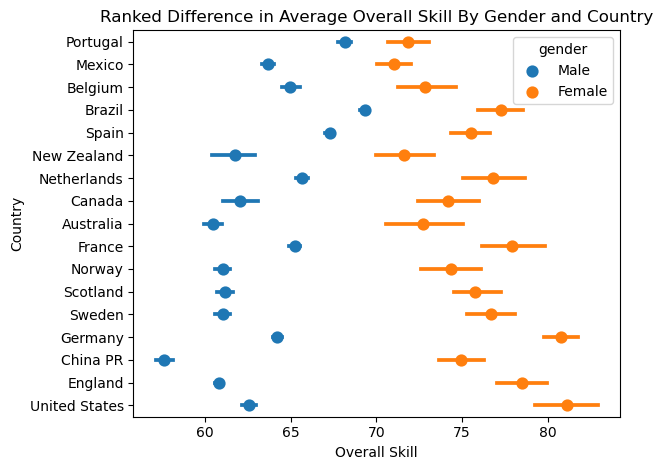

In [111]:
x = df.groupby(["nationality_name", "female"])["overall"].mean().unstack(1)
x = x[x[1].notnull()]
x["diff"] = x[1] - x[0]
x = x.sort_values(by="diff")
z = df.groupby("nationality_name")["female"].max()

fig, ax = plt.subplots()
sns.pointplot(
    data=df[df["nationality_name"].isin(z[z > 0].index)],
    x="overall",
    y="nationality_name",
    orient="h",
    hue="gender",
    join=False,
    order=x.index,
    ax=ax
)
ax.set_xlabel("Overall Skill")
ax.set_ylabel("Country")
ax.set_title("Ranked Difference in Average Overall Skill By Gender and Country")
fig.tight_layout()

We can see that some countries have a small difference, like Portugal and Spain; while others like the United States, England and China have very large differences in skill. Even more so, it looks like female players are more skilled than males across all countries:

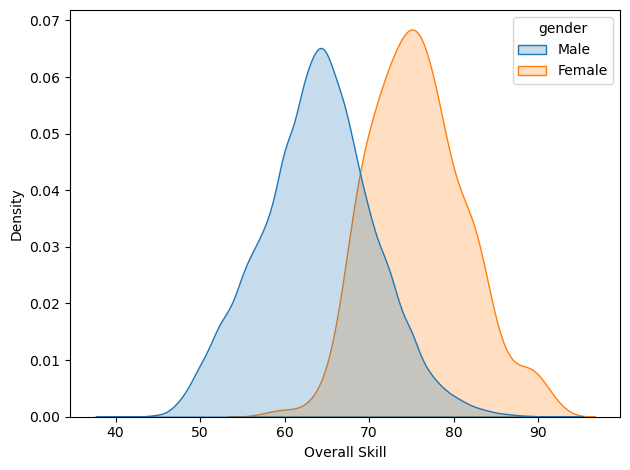

In [112]:
fig, ax = plt.subplots()
sns.kdeplot(data=df, x="overall", hue="gender", ax=ax, common_norm=False, fill=True, legend=True)
ax.set_xlabel("Overall Skill")
fig.tight_layout()

The skill distributions have some overlap, but they also have substantial separation. We do a simple statistical test, testing the hypothesis that the two distributions have the same mean. We can reject that hypothesis very strongly; the difference is statistically significant!

So it looks like for the players that EA decides to feature in their flagship game, females are more skilled than male players. But do their trade values reflect this discrepancy?

Unfortunately, we cannot answer this question directly. Many female players don't have a value in the dataset because either the clubs they're signed with are not featured in the game, or because they simply are not signed to a club. As a way to still do the comparison, we will predict the trade value for players using an ensemble machine learning method.

If we try to take a look at the distribution of trade values we get the following:

<Axes: xlabel='value_us', ylabel='Density'>

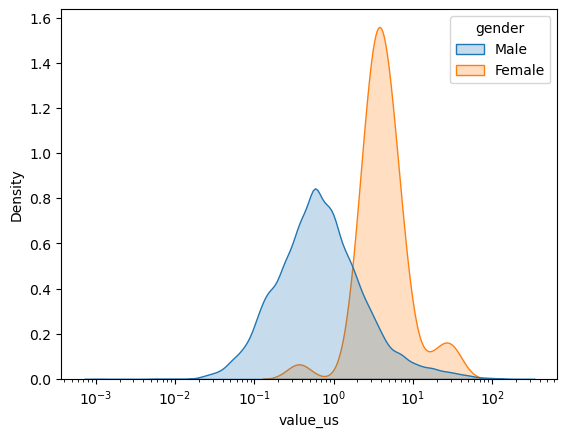

In [113]:
sns.kdeplot(data=df, x="value_us", hue="gender", common_norm=False, fill=True, log_scale=True)

Both distributions look quite different, with the female value distribution being a lot less normal. If we take a look at how the relationship between a player's skill and their value by gender, we don't get a great picture because so many female players are missing value data:

<Axes: xlabel='overall', ylabel='value_us'>

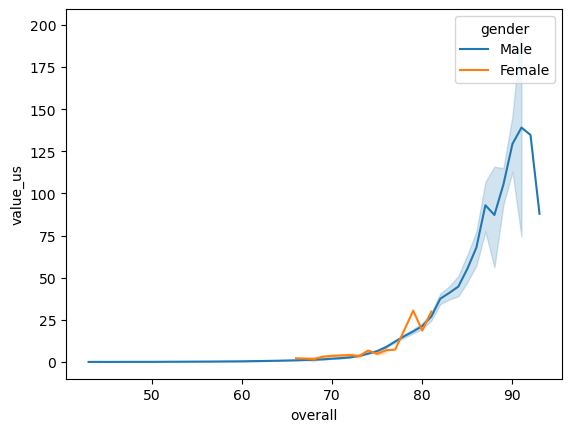

In [114]:
sns.lineplot(
    data=df,
    x="overall",
    y="value_us",
    hue="gender"
)

Let's import our pre-trained model and generate predictions for everyone and check how our predictions look like:

In [115]:
model = FIFAModel.from_joblib()
df["value_eur_pred"] = model.predict(df)
df["value_us_pred"] = df["value_eur_pred"] * 1.1275 / 1000000

<Axes: xlabel='value_us_pred', ylabel='Density'>

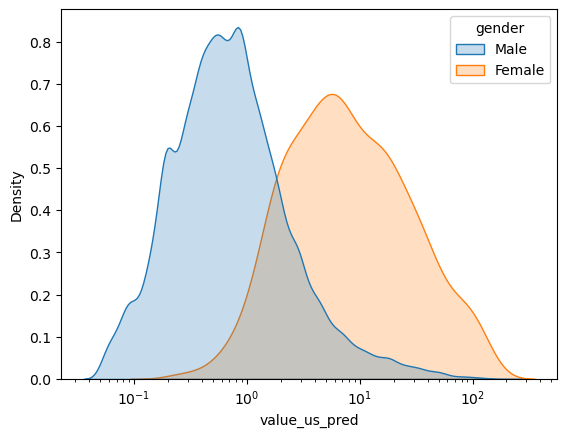

In [116]:
sns.kdeplot(data=df, x="value_us_pred", hue="gender", common_norm=False, fill=True, log_scale=True)

It looks like females are valued more highly than male players. But this could be due to how EA decides to create the player roster each year. We saw before that there are many more male players than female players, and it's reasonable to think that it's easier to make it into the game as a male player than as a female player. This means that we don't see the real distribution of female players because only the very good ones make it into the game.

If we compare male and female players conditional on having the same overall skill score, we see that the pay discrepancies dissapear:

<Axes: xlabel='overall', ylabel='value_us_pred'>

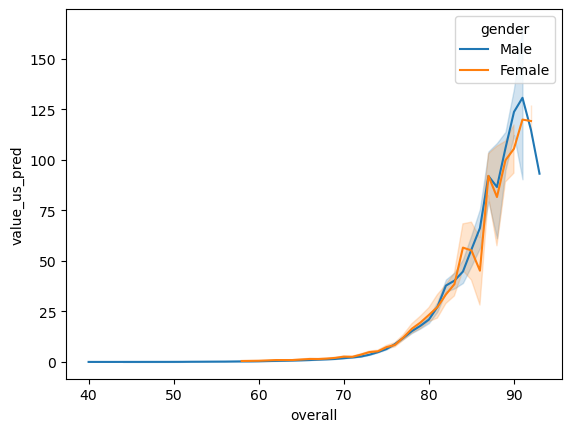

In [117]:
sns.lineplot(
    data=df,
    x="overall",
    y="value_us_pred",
    hue="gender"
)

Does this mean that there is no wage cap? We cannot answer the question with the vanilla data because it's missing those values, and the predictions we generated could be flawed since the data we used to generate the predictions has a bias.

The best we can do is to match each female player to a male player, as close as possible on the things we observe on the data, and ask whether being female is associated with a difference in trade value. We can do this with OLS, the econometric tool of choice when doing causal inference.

When we run this analysis with only the data that we can see, we find that females players are under-valued by about $2 million relative to male players with similar attributes. However, when we run the same analysis using our predicted values, we find that female players are over-valued by about $7 million relative to male players with similar attributes.

In the case where we only look at the data that EA uses, we see that female players are under-paid; this might be reflective of a real wage gap that could be explained by the competitiveness of the player markets for female and male players. On the other hand, when we use our predictive values, we see that females are more highly valued than male players of similar ability. This might reflect the fact that female players that make it into the roster are much better than the average male player that makes it into the roster.

In [118]:
# running OLS with original values
dfols = df[df["value_eur"].notnull()]
mod = sm.OLS(
    endog = dfols["value_us"],
    exog = dfols[["female"] + FEATURES["con"]],
)
res = mod.fit(cov_type="HC3", use_t=True)
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                 OLS Regression Results                                
Dep. Variable:               value_us   R-squared (uncentered):                   0.373
Model:                            OLS   Adj. R-squared (uncentered):              0.372
Method:                 Least Squares   F-statistic:                              230.7
Date:                Sun, 20 Aug 2023   Prob (F-statistic):                        0.00
Time:                        21:39:58   Log-Likelihood:                     -1.2052e+05
No. Observations:               39951   AIC:                                  2.411e+05
Df Residuals:                   39906   BIC:                                  2.415e+05
Df Model:                          45         

In [119]:
# running OLS with predicted values
mod = sm.OLS(
    endog = df["value_us_pred"],
    exog = df[["female"] + FEATURES["con"]],
)
res = mod.fit(cov_type="HC3", use_t=True)
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                 OLS Regression Results                                
Dep. Variable:          value_us_pred   R-squared (uncentered):                   0.403
Model:                            OLS   Adj. R-squared (uncentered):              0.403
Method:                 Least Squares   F-statistic:                              220.1
Date:                Sun, 20 Aug 2023   Prob (F-statistic):                        0.00
Time:                        21:39:58   Log-Likelihood:                     -1.2813e+05
No. Observations:               41149   AIC:                                  2.564e+05
Df Residuals:                   41104   BIC:                                  2.567e+05
Df Model:                          45         